In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split


2024-12-23 14:40:45.860488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734954045.968760     987 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734954045.995769     987 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 14:40:46.252015: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('LAST_DATA.csv')

In [3]:
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df.set_index('DATETIME',inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104361 entries, 2016-01-01 00:20:00 to 2022-02-24 06:20:00
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   RUZGARYON     104361 non-null  float64
 1   RUZGARHIZ     104361 non-null  float64
 2   SICKURU       104361 non-null  float64
 3   NISPINEM      104361 non-null  float64
 4   BASINCAKTUEL  104361 non-null  float64
 5   HADISE0       104361 non-null  object 
 6   HADISE1       104361 non-null  object 
 7   GHADISE0      104361 non-null  object 
 8   BLT0CINS      104361 non-null  float64
 9   BLT0YUK       104361 non-null  float64
 10  AY            104361 non-null  int64  
 11  SAAT          104361 non-null  int64  
 12  MEVSIM        104361 non-null  int64  
dtypes: float64(7), int64(3), object(3)
memory usage: 11.1+ MB


In [5]:
numerical_features = ['RUZGARYON', 'RUZGARHIZ', 'SICKURU', 'NISPINEM', 'BASINCAKTUEL', 'BLT0CINS', 'BLT0YUK', 'AY,', 'SAAT,', 'MEVSIM']
categorical_features = ['HADISE0', 'HADISE1', 'GHADISE0']
target_features = ['SICKURU','BASINCAKTUEL','RUZGARHIZ','NISPINEM']

In [6]:
label_encoders = {}

for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))


In [7]:
df=df.resample('h').mean().ffill()


In [9]:
df.to_csv('final_data.csv')

In [8]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53911 entries, 2016-01-01 00:00:00 to 2022-02-24 06:00:00
Freq: h
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RUZGARYON     53911 non-null  float64
 1   RUZGARHIZ     53911 non-null  float64
 2   SICKURU       53911 non-null  float64
 3   NISPINEM      53911 non-null  float64
 4   BASINCAKTUEL  53911 non-null  float64
 5   HADISE0       53911 non-null  float64
 6   HADISE1       53911 non-null  float64
 7   GHADISE0      53911 non-null  float64
 8   BLT0CINS      53911 non-null  float64
 9   BLT0YUK       53911 non-null  float64
 10  AY            53911 non-null  float64
 11  SAAT          53911 non-null  float64
 12  MEVSIM        53911 non-null  float64
dtypes: float64(13)
memory usage: 5.8 MB


(53911, 13)

In [9]:
shift_days=7
shift_steps= 24*shift_days


In [10]:
df_targets = df[target_features].shift(-shift_steps)
df_targets.head(5)

,SICKURU,BASINCAKTUEL,RUZGARHIZ,NISPINEM
DATETIME,,,,
2016-01-01 00:00:00,13.3,992.85,2.5,68.0
2016-01-01 01:00:00,13.6,991.65,3.0,57.0
2016-01-01 02:00:00,12.2,991.00,4.0,62.0
2016-01-01 03:00:00,12.3,990.60,5.0,65.5
2016-01-01 04:00:00,12.5,991.10,6.5,67.5


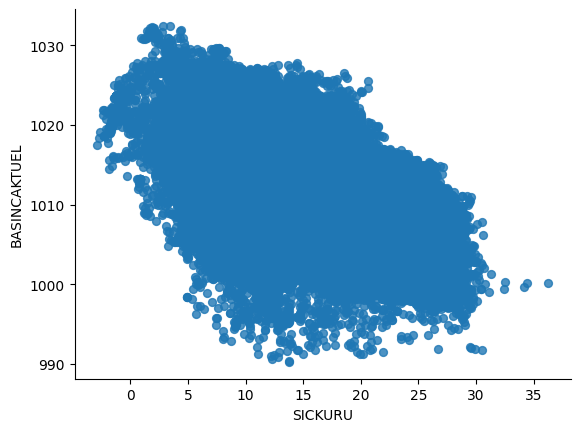

In [13]:
# @title SICKURU vs BASINCAKTUEL

from matplotlib import pyplot as plt
df_targets.plot(kind='scatter', x='SICKURU', y='BASINCAKTUEL', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

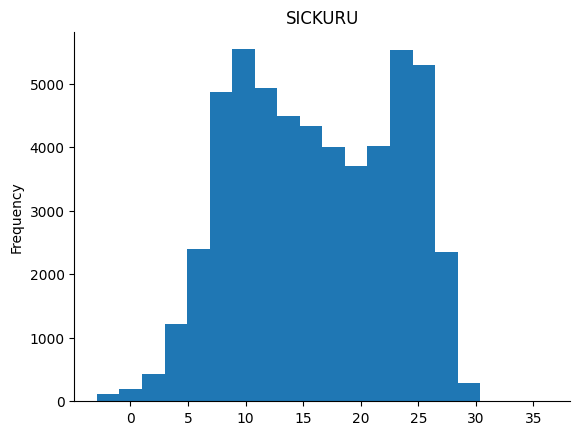

In [ ]:
# @title SICKURU

from matplotlib import pyplot as plt
df_targets['SICKURU'].plot(kind='hist', bins=20, title='SICKURU')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
df_targets.info()
df_targets.shape


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53911 entries, 2016-01-01 00:00:00 to 2022-02-24 06:00:00
Freq: h
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SICKURU       53743 non-null  float64
 1   BASINCAKTUEL  53743 non-null  float64
 2   RUZGARHIZ     53743 non-null  float64
 3   NISPINEM      53743 non-null  float64
dtypes: float64(4)
memory usage: 2.1 MB


(53911, 4)

In [12]:
df_targets.tail(5)

,SICKURU,BASINCAKTUEL,RUZGARHIZ,NISPINEM
DATETIME,,,,
2022-02-24 02:00:00,NaN,NaN,NaN,NaN
2022-02-24 03:00:00,NaN,NaN,NaN,NaN
2022-02-24 04:00:00,NaN,NaN,NaN,NaN
2022-02-24 05:00:00,NaN,NaN,NaN,NaN
2022-02-24 06:00:00,NaN,NaN,NaN,NaN


In [14]:
x_data = df.values[0:-shift_steps]

print(type(x_data))
print('Shape: {}'.format(x_data.shape))


<class 'numpy.ndarray'>
Shape: (53743, 13)


In [117]:
y_data = df_targets.values[:-shift_steps]
print('Shape: {}'.format(y_data.shape))

Shape: (53743, 4)


In [118]:
num_data=len(x_data)
print(num_data)

53743


In [119]:
num_x_signals=x_data.shape[1]
num_y_signals=y_data.shape[1]
print(num_x_signals)
print(num_y_signals)

13
4


In [121]:
X_temp, X_test, y_temp, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, shuffle=False)

In [122]:
print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (34395, 13)
X_val.shape: (8599, 13)
X_test.shape: (10749, 13)
y_train.shape: (34395, 4)
y_val.shape: (8599, 4)
y_test.shape: (10749, 4)


In [123]:
# MinMaxScaler kullanarak verileri ölçeklendir
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Hedef değişkenleri de ölçeklendir
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

print("Ölçeklendirilmiş veri şekilleri:")
print("X_train:", X_train_scaled.shape)
print("X_val:", X_val_scaled.shape)
print("X_test:", X_test_scaled.shape)
print("y_train:", y_train_scaled.shape)
print("y_val:", y_val_scaled.shape)
print("y_test:", y_test_scaled.shape)

Ölçeklendirilmiş veri şekilleri:
X_train: (34395, 13)
X_val: (8599, 13)
X_test: (10749, 13)
y_train: (34395, 4)
y_val: (8599, 4)
y_test: (10749, 4)


In [124]:
def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:i + sequence_length])
        ys.append(y[i + sequence_length])
    return np.array(Xs), np.array(ys)

sequence_length = shift_steps

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

print("X_train_seq.shape:", X_train_seq.shape)  # (34228, 168, 13)
print("y_train_seq.shape:", y_train_seq.shape)  # (34228, 4)

X_train_seq.shape: (34227, 168, 13)
y_train_seq.shape: (34227, 4)


In [139]:
model = Sequential()

# İlk GRU katmanı
model.add(GRU(units=128, input_shape=(sequence_length, num_x_signals), return_sequences=True))
model.add(Dropout(0.2))

# İkinci GRU katmanı
model.add(GRU(units=64, return_sequences=False))
model.add(Dropout(0.2))


# Çıkış katmanı
model.add(Dense(units=num_y_signals, activation='sigmoid'))

/home/samedfrkan/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [126]:
print(model.input_shape)
print(model.output_shape)

(None, 168, 13)
(None, 4)


In [127]:
# Then, update the loss function to handle 2D outputs
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred
    
    y_true: desired output (batch_size, num_y_signals)
    y_pred: model's output (batch_size, num_y_signals)
    """
    # Calculate the MSE loss
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    return loss


In [144]:
model.compile(optimizer=RMSprop(learning_rate=0.1e-3), loss=loss_mse_warmup, metrics=['mae'])

In [140]:
print(model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_20 (GRU)                    │ (None, 168, 128)       │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_21 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,420 (361.02 KB)

 Trainable params: 92,420 (361.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [141]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='/home/samedfrkan/WeatherForecast/23_checkpoint.weights.h5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True),
    TensorBoard(log_dir='./logs/', histogram_freq=1, write_graph=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-5, patience=3, verbose=1)
]

In [142]:
# Check if GPU is available and set the device accordingly
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("Using GPU")
else:
    device = '/CPU:0'
    print("Using CPU")

Using GPU


In [145]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
533/535 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 256756.3125 - mae: 276.0401
Epoch 1: val_loss improved from inf to 256695.48438, saving model to /home/samedfrkan/WeatherForecast/23_checkpoint.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 256755.8750 - mae: 276.0391 - val_loss: 256695.4844 - val_mae: 275.7375 - learning_rate: 1.0000e-04
Epoch 2/20
533/535 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 256655.0781 - mae: 275.7407
Epoch 2: val_loss improved from 256695.48438 to 256695.40625, saving model to /home/samedfrkan/WeatherForecast/23_checkpoint.weights.h5
535/535 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 256655.0781 - mae: 275.7407 - val_loss: 256695.4062 - val_mae: 275.7350 - learning_rate: 1.0000e-04
Epoch 3/20
533/535 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 256654.1562 - mae: 275.7852
Epoch 3: val_loss did not improve from 256695.40625
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 256654.1719 - mae: 275.7849 - val_loss: 256695.4062 - val_mae: 27

In [146]:
y_pred = model.predict(X_test_seq)


331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [147]:
print(y_pred.shape)

(10581, 4)


In [148]:
y_pred_original = scaler_y.inverse_transform(y_pred)

In [149]:
print(y_pred_original.shape)
print(y_pred_original)

(10581, 4)
[[  36.24477  1032.4498     19.99432    99.997116]
 [  36.24477  1032.4498     19.994322   99.997116]
 [  36.244778 1032.4498     19.994324   99.997116]
 ...
 [  36.244854 1032.4498     19.994394   99.99719 ]
 [  36.244854 1032.4498     19.994394   99.99719 ]
 [  36.244854 1032.4498     19.994394   99.99719 ]]


In [58]:
print(y_test.shape)

(10749, 4)


In [62]:
y_test_actual = y_test[sequence_length:]
print(y_test_actual.shape)
print(y_test_actual)

(10581, 4)
[[  14.3  1016.8     8.5    60.  ]
 [  14.3  1016.8     8.5    60.  ]
 [  14.3  1016.8     8.5    60.  ]
 ...
 [  16.1  1010.6     3.5    36.5 ]
 [  15.2  1011.05    1.5    49.5 ]
 [  12.   1011.6    11.     77.  ]]


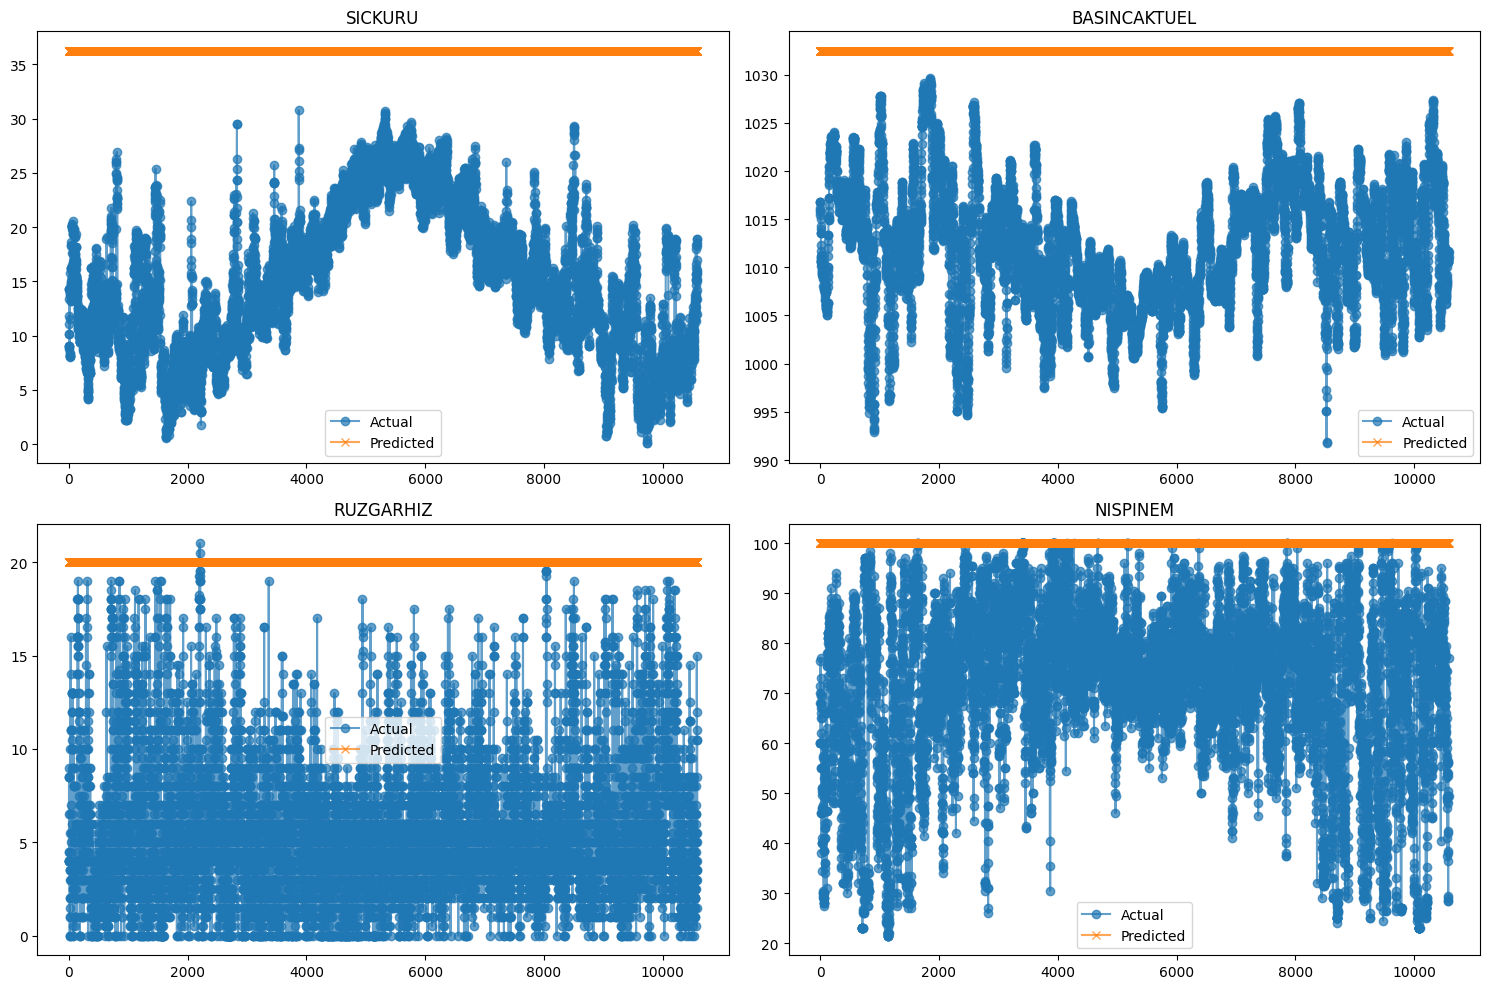

In [85]:
# Predictions

# Plotting
plt.figure(figsize=(15, 10))    
for i, feature in enumerate(target_features):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_actual[:, i], label='Actual', marker='o',alpha=0.7)
    plt.plot(y_pred_original[:, i], label='Predicted', marker='x',alpha=0.7)
    plt.title(feature)
    plt.legend()
plt.tight_layout()
plt.show()

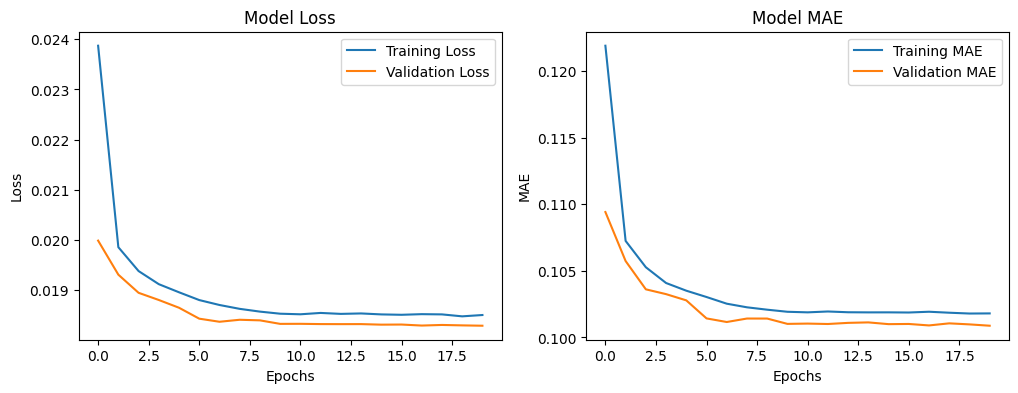

In [64]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()



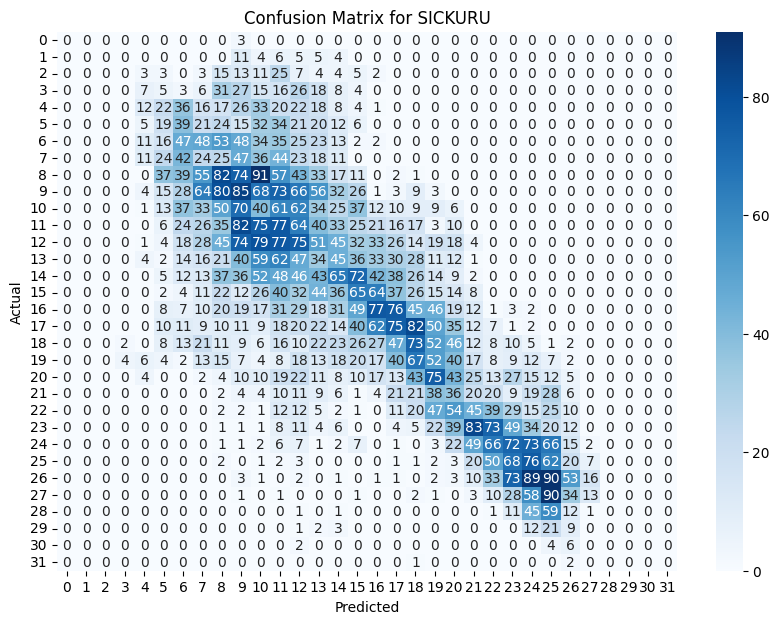

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
y_test_categorical = np.round(y_test_actual[:, 0]).astype(int)
y_pred_categorical = np.round(y_pred_original[:, 0]).astype(int)

conf_matrix = confusion_matrix(y_test_categorical, y_pred_categorical)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for ' + target_features[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [67]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

accuracy = accuracy_score(y_test_categorical, y_pred_categorical)
recall = recall_score(y_test_categorical, y_pred_categorical, average='macro')
f1 = f1_score(y_test_categorical, y_pred_categorical, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.1185
Recall: 0.0902
F1 Score: 0.0897


In [203]:
# Ensure y_test_scaled and y_pred_combined have the same length
num_samples = min(len(y_test_scaled), len(y_pred_combined))

# Convert predictions and true values to original scale
y_pred_original = scaler_y.inverse_transform(y_pred_combined[:num_samples].reshape(-1, y_data.shape[1]))
y_test_original = scaler_y.inverse_transform(y_test_scaled[:num_samples].reshape(-1, y_data.shape[1]))

# Assuming the first target feature is categorical for confusion matrix
y_test_categorical = np.round(y_test_original[:, 0]).astype(int)
y_pred_categorical = np.round(y_pred_original[:, 0]).astype(int)

# Check if lengths match
print(f"Length of y_test_categorical: {len(y_test_categorical)}")
print(f"Length of y_pred_categorical: {len(y_pred_categorical)}")

# Calculate metrics
accuracy = accuracy_score(y_test_categorical, y_pred_categorical)
recall = recall_score(y_test_categorical, y_pred_categorical, average='macro')
f1 = f1_score(y_test_categorical, y_pred_categorical, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Length of y_test_categorical: 63
Length of y_pred_categorical: 10584


ValueError: Found input variables with inconsistent numbers of samples: [63, 10584]

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print('Error trying to load checkpoint.\n{}'.format(error))